<a href="https://colab.research.google.com/github/rasim321/Book_Recommender/blob/main/Book_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Book Recommender

#Content:

## **Part 1: Book Recommender using Clustering Techniques**



## **Part 2: Scraping GoodReads Using BookLists and Titles**


## **Part 3: Book Recommender using BERT**


## **Part 4: Improving the Book Recommender with tags data**



---



---





## **Part 1: Book Recommender using Clustering Techniques**


 Using pre-made Goodreads dataset to recommend books


*Adapted from Aatush Mishra [https://www.kaggle.com/aayushmishra1512]*



---


In [1]:

#Part1: Book Recommender from Pre-downloaded Dataset (#Adapted from Aayush Mishra [https://www.kaggle.com/aayushmishra1512])
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tabulate import tabulate


#Part 2: GoodReads Scraper
import argparse
from datetime import datetime
import json
import os
import re
import time
from urllib.request import urlopen
from urllib.error import HTTPError
import bs4
from googlesearch import search 

#Part 3: Book Recommender using BERT

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')
!pip install -U sentence-transformers
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 81kB 3.8MB/s 
     |████████████████████████████████| 2.1MB 7.6MB/s 
     |████████████████████████████████| 1.2MB 29.8MB/s 
     |████████████████████████████████| 901kB 21.8MB/s 
     |████████████████████████████████| 3.3MB 34.9MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.0-cp37-none-any.whl size=119615 sha256=52542e2277836301ad093a15c35c90ae63c9790d0d4bcafbd114db1684fb9004
  Stored in directory: /root/.cache/pip/wheels/84/cb/21/1066bff3027215c760ca14a198f698bca8fccb92e33e2327eb
Successfully built sentence-transformers


In [133]:

#Upload the 'books.csv' dataset
from google.colab import files
uploaded = files.upload()

Saving books.csv to books.csv


In [146]:
#Load the books.csv data
df = pd.read_csv("books.csv", error_bad_lines=False)

#Let's see the data
df.head()

b'Skipping line 3350: expected 12 fields, saw 13\nSkipping line 4704: expected 12 fields, saw 13\nSkipping line 5879: expected 12 fields, saw 13\nSkipping line 8981: expected 12 fields, saw 13\n'


,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


Variables: 

**bookID** - Contains the unique ID for each book/series

**title** - contains the titles of the books

**authors** - contains the author of the particular book

**average_rating**- the average rating of the books, as decided by the users

**ISBN** - Another unique number to identify the book, the International Standard Book Number.

**ISBN 13** - A 13-digit ISBN to identify the book, instead of the standard 11-digit ISBN.

**language_code** - Helps understand what is the primary language of the book. For instance, eng is standard for English.

**num_pages** - Number of pages the book contains.

**ratings_count** - Total number of ratings the book received.

**text_reviews_count** - Total number of written text reviews the book received.




In [135]:

#How many unique titles
books_n = len(df["title"].unique())
print(f'There are {books_n} unique books in the dataset')

#And unique authors?
author_n = len(df["authors"].unique())
print(f'And there are {author_n} unique authors')

pro_auth_one = df.authors.mode()[0]
pro_auth_two = df.authors.mode()[1]

print(f'The two most prolific authors are {pro_auth_one} and {pro_auth_two} who\
 each penned 40 books.')


There are 10348 unique books in the dataset
And there are 6639 unique authors
The two most prolific authors are P.G. Wodehouse and Stephen King who each penned 40 books.


In [136]:

#Let's find the top 20 books by ratings

#Sorting books by those rated over 100k times
df_high_rate = df.loc[df["ratings_count"] > 100000]

#Collecting the top 20 books
top20 = df_high_rate.sort_values(by="average_rating", ascending = False).head(20)

#Using tabulate for better looking tables
print(tabulate(top20[["title","authors","average_rating"]], headers=['title','author','rating']))

       title                                                                                   author                                                               rating
-----  --------------------------------------------------------------------------------------  -----------------------------------------------------------------  --------
   21  J.R.R. Tolkien 4-Book Boxed Set: The Hobbit and The Lord of the Rings                   J.R.R. Tolkien                                                         4.59
    0  Harry Potter and the Half-Blood Prince (Harry Potter  #6)                               J.K. Rowling/Mary GrandPré                                             4.57
    3  Harry Potter and the Prisoner of Azkaban (Harry Potter  #3)                             J.K. Rowling/Mary GrandPré                                             4.56
 4244  The Complete Maus                                                                       Art Spiegelman                                    

Unsurprisingly, the Lord of the Rings and Harry Potter novels rank numerous times on the list. More surprising is the popularity of manga and graphic novels such as Fullmetal Alchemist, Death Note, and Maus. Another important finding here is that the highest rating among these books is a 4.6. If we look at this ratings blindly, 4.6 may seem like a low to mediocre rating for a book. However, the range of Goodreads ratings are important to consider.  

In [137]:

#Let's see the same list but by number of ratings:

top20_r = df.sort_values(by="ratings_count", ascending = False).head(20)

print(tabulate(top20_r[["title","authors","ratings_count"]]))


-----  ------------------------------------------------------------  --------------------------------------------------  -------
10336  Twilight (Twilight  #1)                                       Stephenie Meyer                                     4597666
 1697  The Hobbit  or There and Back Again                           J.R.R. Tolkien                                      2530894
 1462  The Catcher in the Rye                                        J.D. Salinger                                       2457092
  307  Angels & Demons (Robert Langdon  #1)                          Dan Brown                                           2418736
    3  Harry Potter and the Prisoner of Azkaban (Harry Potter  #3)   J.K. Rowling/Mary GrandPré                          2339585
 4415  Harry Potter and the Chamber of Secrets (Harry Potter  #2)    J.K. Rowling/Mary GrandPré                          2293963
    1  Harry Potter and the Order of the Phoenix (Harry Potter  #5)  J.K. Rowling/Mary GrandPré  

For the number of ratings, Twilight far exceeds other books. This may not be all positive reviews, but the vampire novel did attract a lot of opinions. Notice that this is table excludes books that have less than 100,000 ratings. This is to exclude books which have only a few stellar ratings. 

Text(0, 0.5, 'Titles')

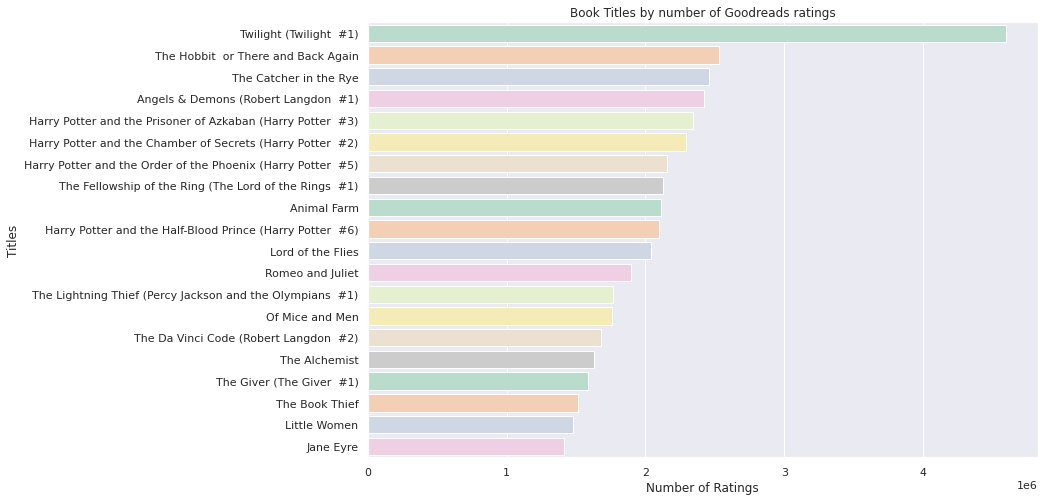

In [147]:

#Let's order the books by the number of reviews
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x="ratings_count", y="title", data=top20_r, palette='Pastel2').set_title('Book Titles by number of Goodreads ratings')
plt.xlabel("Number of Ratings")
plt.ylabel("Titles")

It's hard to overestimate how popular the first Twilight book is. The number of ratings is head and shoulders above the second most rated book, "The Hobbit." Also notable is that The Catcher in the Rye and Angels & Demons both have more ratings than the Harry Potter books. 

In [163]:
#Seperate the english books from the dataset

eng = df[df["language_code"]=="eng"]
eng.shape

(8908, 12)

The English language only dataset has 8908 books. 

In [139]:
#Let's make our book recommender

#First we create dummy variables for the ratings
eng.loc[ (eng['average_rating'] >= 0) & (eng['average_rating'] <= 1), 'rating_between'] = "between 0 and 1"
eng.loc[ (eng['average_rating'] > 1) & (eng['average_rating'] <= 2), 'rating_between'] = "between 1 and 2"
eng.loc[ (eng['average_rating'] > 2) & (eng['average_rating'] <= 3), 'rating_between'] = "between 2 and 3"
eng.loc[ (eng['average_rating'] > 3) & (eng['average_rating'] <= 4), 'rating_between'] = "between 3 and 4"
eng.loc[ (eng['average_rating'] > 4) & (eng['average_rating'] <= 5), 'rating_between'] = "between 4 and 5"

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [140]:

#Let's get the features for the KNN model
ratings = pd.get_dummies(eng["rating_between"])
features = pd.concat([ratings, eng['average_rating'], eng['ratings_count']], axis=1)
features.head()

#Processing
scaler = MinMaxScaler()
features = scaler.fit_transform(features)


In [143]:
#Fit the knn model
knn_model = neighbors.NearestNeighbors(n_neighbors=4, algorithm='ball_tree')
knn_model.fit(features)

#Get the distance between each book pair among neighhbors, and the id of the books
dist, idlist = knn_model.kneighbors(features)

In [144]:

#And create the book recommendation function
def BookRecommender(book_name):
    """
    Takes the name of the book and returns a list of similar books equal to 
    number of n_neighbors

    :param p1: Name of book
    :return: List of similar books equal to number of n_neighbors
    """ 
    book_list = []
    book_id = eng[eng['title'] == book_name].index[0]
    for newid in idlist[book_id]:
        book_list.append(eng.loc[newid].title)
    return book_list

In [164]:
#Let's try it out
BookRecommender("The Alchemist")

['The Alchemist',
 'Huck Finn & Tom Sawyer among the Indians & Other Unfinished Stories (Mark Twain Library)',
 'Tom Jones',
 'The Journals of Sylvia Plath']

The Book Recommender is not so effective. Is Huck Finn and Tom Sawyer's stories really a good recommendation for The Alchemist? The fans of The Alchemist would certainly disagree. The Book Recommender does not work very well because it only uses average ratings and rating_counts to provide recommendations. The best it can do is recommend similarly popular books. 

 ## Can we improve this Recommender?

To do so, we would need more data from Goodreads. With richer data such as plot summaries and tags data, we can build a better algorithm that recommends books that make intuitive sense. 

---

#Part 2: Web-Scraping GoodReads


Build our own dataset by web-scraping Goodreads



---








In [2]:
# Two fucntions: One that gets ratings metadata from GoodReads book links, and 
# a second function that retrieves metadata on plot summary, tags data, and 
# review counts

def Rater(ratings):
  """
    Takes the ratings input from GoodReads and returns rating average and 
    number of ratings

    :param p1: Ratings input
    :return: average rating and number of ratings
  """ 
  #Lists for Average Rating and Number of Reviews
  rating_avg= []
  rating_num = []

  for i in ratings: 
    rating_avg.append(re.findall("\d+\.\d+", i)[0])
    try: 
      rating_num.append(re.findall("(?<=—)(.*)(?=ratings)",i)[0])
    except IndexError:
      rating_num.append('0')

  rating_avg = [float(i) for i in rating_avg]
  rating_num = [int(j.replace(",", "").strip()) for j in rating_num]

  return rating_avg, rating_num


def GetDetails(links):
  """
    Visits each book link and returns the plot summary, tags, and number of
    reviews.

    :param p1: GoodReads url of books
    :return: plot summary, tags, and number of reviews
  """ 

  url = 'https://www.goodreads.com/'
  plot_df = []
  book_all_tags = []
  n_reviews = []
  count = 0

  for link in links:

    book_page = urlopen(url + link)
    soup = bs4.BeautifulSoup(book_page, "html.parser")
    count += 1

    plots = soup.select('#description span')
    if len(plots) > 1:
      summary = []

      for plot in plots:
        summary.append(plot.text)
      
      plot_df.append(summary[1])
        
    else:
      for plot in plots:
        plot_df.append(plot.text)



    #Get book tags
    book_tags = []

    tags = soup.select('.bookPageGenreLink')
    for tag in tags:
      book_tags.append(tag.text)

    book_tags = [x for x in book_tags if not any(c.isdigit() for c in x)]
    book_all_tags.append(book_tags)
    time.sleep(1)
    print("Book: " + str(count) +  " out of " + str(len(links)))


    #Get Number of Reviews:
    reviews = soup.select('.reviewControls--left.greyText')
    rev = []
    for review in reviews:
      rev.append(review.text)
    rev = re.findall("\s\d+\s|\d+,\d+", rev[0])
    rev = [item.replace(",", "") for item in rev]
    n_reviews.append(int(rev[1]))
    
  return plot_df, book_all_tags, n_reviews
  


In [3]:
#@title Default title text
# book_page = urlopen('https://www.goodreads.com/book/show/6690979-black-butler-vol-1')
# soup = bs4.BeautifulSoup(book_page, "html.parser")

def BookDetails(links, title_data=False, author_data=False, ratings_data = False):
  """
    Takes links tobook titles and returns a dataframe of information about each 
    book.

    :param p1: GoodReads links to the book
    :param p2: title_data = True if title data is needed
    :param p3: author_data = True if author data is needed
    :param p4: ratings_data = True if ratings data is needed
    :return: Dataframe of information for each book: title, author, avg rating, 
    number of ratings, plot summary, tags, and number of reviews
  """ 

  url = 'https://www.goodreads.com/'

  #Additonal Details
  title_df = []
  author_df = []
  avg_rating_df = []
  ratings_num_df = []

  #Regular details
  plot_df = []
  book_all_tags = []
  n_reviews = []
  count = 0

  for link in links:
  
    #check if link is the full url or just book link
    if "goodreads" in link:
      book_page = urlopen(link)
    else:
      book_page = urlopen(url + link)

    #Create the BS object
    soup = bs4.BeautifulSoup(book_page, "html.parser")
    count += 1

    #Check if title data is required
    if title_data == True:
      title = soup.select('#bookTitle')
      for j in title:
        title_df.append(j.text.strip())
    else:
      pass
    
    #Check if author data is required
    if author_data == True:
      author = soup.find("span", itemprop="name").text
      author_df.append(author)
    else:
      pass
    
    #Check if ratings data is required
    if ratings_data == True:
      rating = soup.find("span", itemprop="ratingValue")
      for l in rating:
        avg_rating_df.append(float(l.strip()))
      
      ratings_num = soup.find("meta", itemprop="ratingCount").get('content')
      ratings_num_df.append(ratings_num)
    else:
      pass


    #Get plot summaries
    plots = soup.select('#description span')
    if len(plots) > 1:
      summary = []

      for plot in plots:
        summary.append(plot.text)
      
      plot_df.append(summary[1])
        
    else:
      for plot in plots:
        plot_df.append(plot.text)



    #Get book tags
    book_tags = []

    tags = soup.select('.bookPageGenreLink')
    for tag in tags:
      book_tags.append(tag.text)

    book_tags = [x for x in book_tags if not any(c.isdigit() for c in x)]
    book_all_tags.append(book_tags)
    time.sleep(1)
    print("Book: " + str(count) +  " out of " + str(len(links)))


    #Get Number of Reviews:
    n_review = soup.find("meta", itemprop="reviewCount").get('content')
    n_reviews.append(n_review)
  
  if title_data==False:
    title_df = [None] * len(links)
  if author_data==False:
    author_df = [None] * len(links)
  if ratings_data==False:
    avg_rating_df = [None] * len(links)
    ratings_num_df = [None] * len(links)
    
  book_df = pd.DataFrame({
      'title': title_df,
      'author': author_df,
      "avg_rate": avg_rating_df,
      "number_of_ratings": ratings_num_df,
      "plot_summary": plot_df,
      "tags": book_all_tags,
      "reviews": n_reviews
  })
  return book_df



In [4]:
#How to get book page details from book titles: 

#
def BookLinks(query):
  """
    Take a list of book titles and returns an array of links.

    :param p1: List of book titles
    :return: Array of book links from GoodReads
  """ 

  #Empty list to store links
  links = []

  #Search each search query
  for q in query:
    # print(q)

    #Specify search feature in goodreads.com
    url = ' site: goodreads.com'

    #Add the search query to the search term
    search_q = str(q) + url

    #Get the goodreads link 
    gdrd_l = search(search_q, tld="com", num=1, stop=1, pause=2)

    #Append to list
    for i in gdrd_l:
      links.append(i)
  
  #Return the list
  return links
  

In [5]:
#ListScraper function to get metadata from GoodReads using GoodReads lists

def ListScraper(link, num_books=1000000):
  """
    ListScraper takes a list of books, gets the author and book names, and the
    individual links to the book's Goodreads pages. It passes the link to Rater
    and GetDetails functions to receive additional data on each book. It returns
    a dataframe of all the above information for all books in the list.

    :param p1: Link to GoodReads book list
    :param p2: number of books to return from the list
    :return: Dataframe with book details: title, author, avg rating, number
    of ratings, link, plot summary, tags, and numnber of reviews.
  """ 
  url = 'https://www.goodreads.com/'

  #Check if the link contains a Goodreads list
  if "list" in link:
    pass
  else:
    print("This link does not contain a GoodReads list")

  #Strip the list url from the full url
  if link.startswith(url):
    list_url = link.replace(url, '')
  else:
    list_url = link

  #Make lists for the data we want
  titles = []
  authors = []
  ratings = []
  book_links = []
  n = 0 #no. of books

  #Loop through the number of pages
  while (list_url != None):

    #Set up the URL
    source = urlopen(url + list_url)
    soup = bs4.BeautifulSoup(source, "html.parser")

    #Get all titles from this page
    books = soup.select(".bookTitle span")
    for book in books:
      titles.append(book.text)
      n += 1
    
    #Get the authors
    writers = soup.select(".authorName span")
    for author in writers:
      authors.append(author.text)

    #Get the ratings:
    rates = soup.select(".minirating")
    for rate in rates:
      ratings.append(rate.text)

    #Get the links:
    links = soup.findAll('a', {'class': 'bookTitle'})
    for link in links:
      book_links.append(link['href'])

    #Check if there is a next page and either end the program or continue to next page
    if not soup.select(".pagination"):
      list_url = None
    else:
      next = soup.select(".pagination")[0].select(".next_page")[0].get('href')
      if next != None:
        list_url = next
        print("Going to next page...")
      else:
        list_url = next
        print("No more pages to scan.")
  
  #If num_books is larger than the total no. of books in the list
  #change num_books to the size of the list n.
  if num_books > n: 
    num_books = n
  else: 
    pass
  
  #Transform string ratings to average and number of ratings
  rating_avg, rating_num = Rater(ratings[0:num_books])

  #Get book details: plot summary, tags, and number of reviews
  plot_df, book_all_tags, num_reviews = GetDetails(book_links[0:num_books])
  
  book_df = pd.DataFrame({
      'title': titles[0:num_books],
      'author': authors[0:num_books],
      "avg_rate": rating_avg[0:num_books],
      "number_of_ratings": rating_num[0:num_books],
      "link": book_links[0:num_books],
      "plot_summary": plot_df[0:num_books],
      "tags": book_all_tags[0:num_books],
      "reviews": num_reviews[0:num_books]
  })
  
  return book_df

In [6]:
#Let's try and improve list scraper by adding:
#1. an argument for the number of books we want to download [CHECK]
#2. a checkpointing system so that if something goes wrong we do not lose the whole dataframe
#3. A way to save the files intermittently (for example, after 50 books)
#4. If program gets halted for some reason, it can restart from a particular check point
#5. If arrays are of different size, handle errors

def ListSaver(link, checkpoint_n = 50, save_csv = False, start_n = 0, num_books=1000000):
  """
    ListScraper takes a list of books, gets the author and book names, and the
    individual links to the book's Goodreads pages. It passes the link to Rater
    and GetDetails functions to receive additional data on each book. It returns
    a dataframe of all the above information for all books in the list.

    :param p1: Link to GoodReads book list
    :param p2: number of books to save at each checkpoint, by default = 50
    :param p3: Boolean to save a csv file at each checkpoint
    :param p4: start at 0 by default, but option to start at some other point
    :param p5: number of total books to save
    :return: Dataframe with book details: title, author, avg rating, number
    of ratings, link, plot summary, tags, and numnber of reviews.
  """ 
  #Check that the checkpoints are smaller than num_books
  assert checkpoint_n < num_books, "checkpoints must be smaller than number of books requested"

  url = 'https://www.goodreads.com/'

  #Check if the link contains a Goodreads list
  if "list" in link:
    pass
  else:
    print("This link does not contain a GoodReads list")

  #Strip the list url from the full url
  if link.startswith(url):
    list_url = link.replace(url, '')
  else:
    list_url = link

  #Make lists for the data we want
  titles = []
  authors = []
  ratings = []
  book_links = []
  n = 0 #no. of books

  #Loop through the number of pages
  while (list_url != None):

    #Set up the URL
    source = urlopen(url + list_url)
    soup = bs4.BeautifulSoup(source, "html.parser")

    #Get all titles from this page
    books = soup.select(".bookTitle span")
    for book in books:
      titles.append(book.text)
      n += 1
    
    #Get the authors
    writers = soup.select(".authorName span")
    for author in writers:
      authors.append(author.text)

    #Get the ratings:
    rates = soup.select(".minirating")
    for rate in rates:
      ratings.append(rate.text)

    #Get the links:
    links = soup.findAll('a', {'class': 'bookTitle'})
    for link in links:
      book_links.append(link['href'])

    #Check if there is a next page and either end the program or continue to next page
    if not soup.select(".pagination"):
      list_url = None
    else:
      next = soup.select(".pagination")[0].select(".next_page")[0].get('href')
      if next != None:
        list_url = next
        print("Going to next page...")
      else:
        list_url = next
        print("No more pages to scan.")
  
  #If num_books is larger than the total no. of books in the list
  #change num_books to the size of the list n.
  if num_books > n: 
    num_books = n
  else: 
    pass
  
  book_master = pd.DataFrame({
      'title': [],
        'author': [],
        "avg_rate": [],
        "number_of_ratings": [],
        "link": [],
        "plot_summary": [],
        "tags": [],
        "reviews": []
        })
  
  #Number of Saves
  save_n = num_books//checkpoint_n
  #Remainder books after the last checkpoint
  save_rem = num_books % checkpoint_n
  #Start_n and End_n
  start = start_n
  end = start + checkpoint_n

  while end <= num_books:

    #Transform string ratings to average and number of ratings
    rating_avg, rating_num = Rater(ratings[start:end])
    print(len(rating_avg), len(rating_num))


    #Get book details: plot summary, tags, and number of reviews
    plot_df, book_all_tags, num_reviews = GetDetails(book_links[start:end])
    print(len(plot_df), len(book_all_tags), len(num_reviews))

    book_dict = {
        'title': titles[start:end],
        'author': authors[start:end],
        "avg_rate": rating_avg,
        "number_of_ratings": rating_num,
        "link": book_links[start:end],
        "plot_summary": plot_df,
        "tags": book_all_tags,
        "reviews": num_reviews
    }

    book_df = pd.DataFrame({key:pd.Series(value) for key, value in book_dict.items()})

    start += checkpoint_n
    end += checkpoint_n
    book_master = book_master.append(book_df, ignore_index = True)
    yield book_master

    #Save
    if save_csv:
      book_master.to_csv(r'books-' + str(start) + '.csv', index=False, header=True)
  
  #Last chunk of books after last savepoint
  
  #Transform string ratings to average and number of ratings
  rating_avg, rating_num = Rater(ratings[start:num_books])
  print(len(rating_avg), len(rating_num))

  #Get book details: plot summary, tags, and number of reviews
  plot_df, book_all_tags, num_reviews = GetDetails(book_links[start:num_books])
  print(len(plot_df), len(book_all_tags), len(num_reviews))
  
  book_end = {
      'title': titles[start:num_books],
      'author': authors[start:num_books-1],
      "avg_rate": rating_avg,
      "number_of_ratings": rating_num,
      "link": book_links[start:num_books],
      "plot_summary": plot_df,
      "tags": book_all_tags,
      "reviews": num_reviews
  }

  book_df = pd.DataFrame({key:pd.Series(value) for key, value in book_end.items()})

  start += checkpoint_n
  end += checkpoint_n
  book_master = book_master.append(book_df, ignore_index = True)
  yield book_master
  
  #Save 
  if save_csv:
    book_master.to_csv(r'books-' + str(num_books) + '.csv', index=False, header=True)
  
  return book_master

  

In [257]:
#FOR BOOKLISTS
# Function 1: ListScraper - to scrape bookreads for a specific list of books
# Function 2: ListSaver - to save a list of books with checkpoints enabled

#2020s
#https://www.goodreads.com/list/show/143500.Best_Books_of_the_Decade_2020_s

book_master = list(ListSaver("https://www.goodreads.com/list/show/7791.Best_School_Assigned_Books",checkpoint_n = 200,save_csv = False, start_n=0))

# book_master.to_csv("name_of_df.csv")

Going to next page...
Going to next page...
Going to next page...
Going to next page...
Going to next page...
Going to next page...
Going to next page...
No more pages to scan.
200 200
Book: 1 out of 200
Book: 2 out of 200
Book: 3 out of 200
Book: 4 out of 200
Book: 5 out of 200
Book: 6 out of 200
Book: 7 out of 200
Book: 8 out of 200
Book: 9 out of 200
Book: 10 out of 200
Book: 11 out of 200
Book: 12 out of 200
Book: 13 out of 200
Book: 14 out of 200
Book: 15 out of 200
Book: 16 out of 200
Book: 17 out of 200
Book: 18 out of 200
Book: 19 out of 200
Book: 20 out of 200
Book: 21 out of 200
Book: 22 out of 200
Book: 23 out of 200
Book: 24 out of 200
Book: 25 out of 200
Book: 26 out of 200
Book: 27 out of 200
Book: 28 out of 200
Book: 29 out of 200
Book: 30 out of 200
Book: 31 out of 200
Book: 32 out of 200
Book: 33 out of 200
Book: 34 out of 200
Book: 35 out of 200
Book: 36 out of 200
Book: 37 out of 200
Book: 38 out of 200
Book: 39 out of 200
Book: 40 out of 200
Book: 41 out of 200
Book

In [258]:
#The lest element in the book_master list will have the complete dataset
book_final = book_master[-1]

#Let's look at the number of rows to get the total number of books in our dataset
book_final.shape

(748, 8)

In [165]:
#FOR BOOK TITLES

#Try passing a list of book names:
#Notice that searching book titles with typos still works with the function:
book_names = ["The godffather", "Snow Orhan Pamuk", "the Da Vinki Code", "treasur island",
              "Harry Potter and the Half Bloood Prince", "the sicilian", "Harry Potter and the Chamber of Secrets",
              "Red Plenty", "Wiseguy", "The Last Don", "Wolf hall", "The Vanishing Half", "Of women and salt",
              "Educated", "The Great Believers", "The Lightning Thief"]


book_final2 = BookDetails(BookLinks(book_names), title_data=True,author_data=True, ratings_data=True)
book_final2

Book: 1 out of 16
Book: 2 out of 16
Book: 3 out of 16
Book: 4 out of 16
Book: 5 out of 16
Book: 6 out of 16
Book: 7 out of 16
Book: 8 out of 16
Book: 9 out of 16
Book: 10 out of 16
Book: 11 out of 16
Book: 12 out of 16
Book: 13 out of 16
Book: 14 out of 16
Book: 15 out of 16
Book: 16 out of 16


,title,author,avg_rate,number_of_ratings,plot_summary,tags,reviews
0,The Godfather,Mario Puzo,4.36,355108,The Godfather—the epic tale of crime and betra...,"[Fiction, Classics, Mystery, Crime, Thriller, ...",9295
1,Snow,Orhan Pamuk,3.59,42523,One of multiple covers for ISBN 9780375706868....,"[Fiction, Literature, Contemporary, Novels, Cu...",3722
2,The Da Vinci Code,Dan Brown,3.87,2021858,ISBN 9780307277671 moved to this edition.While...,"[Fiction, Mystery, Thriller, Suspense, Thrille...",48491
3,Treasure Island,Robert Louis Stevenson,3.84,420210,"""For sheer storytelling delight and pure adven...","[Classics, Fiction, Adventure, Young Adult, Hi...",12476
4,Harry Potter and the Half-Blood Prince,J.K. Rowling,4.57,2593687,The war against Voldemort is not going well; e...,"[Fantasy, Young Adult, Fiction, Fantasy, Magic...",42376
5,The Sicilian,Mario Puzo,3.99,21367,After Mario Puzo wrote his internationally acc...,"[Fiction, Mystery, Crime, Thriller, Historical...",785
6,Harry Potter and the Chamber of Secrets,J.K. Rowling,4.43,2928434,Ever since Harry Potter had come home for the ...,"[Fantasy, Young Adult, Fiction, Fantasy, Magic...",56997
7,Red Plenty,Francis Spufford,4.09,3049,Once upon a time in the Soviet Union....Strang...,"[History, Nonfiction, Cultural, Russia, Econom...",450
8,Wiseguy,Nicholas Pileggi,4.19,14204,"""Wiseguy"" is Nicholas Pileggi's remarkable bes...","[Nonfiction, Crime, True Crime, Mystery, Crime...",721
9,The Last Don,Mario Puzo,3.85,16104,"The last don is Domenico Clericuzio, a wise an...","[Fiction, Mystery, Crime, Thriller, Mystery, N...",517


In [47]:
def Book_Cleaner(book_df):

  """
  Removes missing plot summaries and non-English books from the
  book dataframe

  :param p1: Book Dataframe
  :return: Return cleaned dataframe and plot_summaries
  """

  ## Remove rows with missing plot_summaries

  #Extract the abstracts
  abstracts = book_df['plot_summary']

  #Index of all the complete cases
  abs_null = abstracts.notnull()

  #Dataframe with complete plot_summaries
  book_complete = book_df[abs_null]

  #Get complete abstracts
  abstracts = book_complete['plot_summary']

  #Reset index for both abstracts and dataframe
  book_complete = book_complete.reset_index(drop=True)
  abstracts = abstracts.reset_index(drop=True)

  ## Check for non-English books and remove them

  #Nltk word list
  nltk.download('words')
  words = set(nltk.corpus.words.words())

  #Emplty list for percentage of words in English
  perc_eng = []

  #For each abstract, check what percentage of the words
  #are in English
  for i in abstracts:
    k = re.findall(r'\w+', i)
    count = 0
    for j in k:
      if j in words:
        count += 1
    perc_eng.append(count/len(k))
  

  #Remove all plot_summaries where at least
  #40 percent of the words are not in English
  abs_idx = []
  for i in perc_eng:
    if i > 0.4:
      abs_idx.append(True)
    else:
      abs_idx.append(False)
  
  abstracts = abstracts[abs_idx]
  book_complete = book_complete[abs_idx]
  abstracts = abstracts.reset_index(drop=True)
  book_complete = book_complete.reset_index(drop=True)

  return abstracts, book_complete
    


In [166]:
abstracts2, book_final2 = Book_Cleaner(book_final2)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


## Part 3: Book Recommender
Using Bert encodings to find similar boos

In [12]:
#Load the Bert model from Hugging Face
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [63]:
#Get text embeddings for each abstract
text_embeddings2 = model.encode(abstracts2, batch_size = len(abstracts2), show_progress_bar = True)

In [151]:
#Get the cosine similarity for each abstract
similarities2 = cosine_similarity(text_embeddings2)

#And finally, sort the cosine similarity by ascending order
similarities_sorted2 = similarities2.argsort()

In [152]:
#For each abstract let's get the most similar abstract possible:


def similar_books(title, df, num_books, sorted_list):
  """
  Returns similar books to the book title provided.

  :param p1: Book Title
  :param p2: Dataframe of books to search from
  :param p3: Number of recommendations
  :param p4: The sorted list of books to search from
  :return: Return number of book recommendations equivalent to the num_books
  """

  idx_num = df[df["title"] == title].index.values
  return df["title"][sorted_list[idx_num][0][-2:-(num_books+2):-1]].values

In [169]:
#Let's try it out
similar_books("The Lightning Thief", book_final2, 5, similarities_sorted2)

array(['Harry Potter and the Chamber of Secrets',
       'Harry Potter and the Half-Blood Prince', 'Educated',
       'The Vanishing Half', 'The Great Believers'], dtype=object)

In [168]:
#Finally, let's put it all together:
BookDetails(BookLinks(similar_books("The Godfather", book_final2, 3, similarities_sorted2)), title_data=True,author_data=True, ratings_data=True)

Book: 1 out of 3
Book: 2 out of 3
Book: 3 out of 3


,title,author,avg_rate,number_of_ratings,plot_summary,tags,reviews
0,Wiseguy,Nicholas Pileggi,4.19,14204,"""Wiseguy"" is Nicholas Pileggi's remarkable bes...","[Nonfiction, Crime, True Crime, Mystery, Crime...",721
1,The Sicilian,Mario Puzo,3.99,21367,After Mario Puzo wrote his internationally acc...,"[Fiction, Mystery, Crime, Thriller, Historical...",785
2,The Last Don,Mario Puzo,3.85,16104,"The last don is Domenico Clericuzio, a wise an...","[Fiction, Mystery, Crime, Thriller, Mystery, N...",517


In [129]:
book_final2.title[0:16]

0                               The Godfather
1                                        Snow
2                           The Da Vinci Code
3                             Treasure Island
4      Harry Potter and the Half-Blood Prince
5                                The Sicilian
6     Harry Potter and the Chamber of Secrets
7                                  Red Plenty
8                                     Wiseguy
9                                The Last Don
10    Partisans of Allah: Jihad in South Asia
11                         The Vanishing Half
12                          Of Women and Salt
13                                   Educated
14                        The Great Believers
15                        The Lightning Thief
Name: title, dtype: object

When we search the 3 most similar books to "The Godfather" by Mario Puzo, we find that other organized crime related books are suggested, two of them from the same author even though the author data is not used. 

This works pretty well!



Lets try this on a much larger dataset that we downloaded previously. 

In [67]:
# try_a.to_csv("best_school_assigned_748.csv")
book_final = pd.read_csv("best_school_assigned_748.csv")

In [68]:
#Get the plot_summaries, and the cleaned dataframe
abstracts, book_final = Book_Cleaner(book_final)
book_final.shape

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


(719, 9)

In [69]:
print("After cleaning the data, there remains", len(abstracts), "books in the dataset.")

After cleaning the data, there remains 719 books in the dataset.


In [70]:
#Get text embeddings for each abstract
#These embeddings help us retain semantic and syntactic information about the abstracts. Abstracts that are closer to each other
#In meaning will be closer to each other in the multidimensional space

text_embeddings = model.encode(abstracts, batch_size = len(abstracts), show_progress_bar = True)

In [154]:
#Get the cosine similarity for each abstract
#The cosine simiarity help us determine which abstracts are close 
#to each other based on the embeddings.

similarities = cosine_similarity(text_embeddings)
# print('pairwise dense output:\n {}\n'.format(similarities))

In [155]:
#And finally, sort the cosine similarity by ascending order
similarities_sorted = similarities.argsort()

In [73]:
book_final.title[0:50]

0                                 To Kill a Mockingbird
1                             The Giver (The Giver, #1)
2                                         The Outsiders
3                                           Animal Farm
4                                                  1984
5                                      The Great Gatsby
6                                     Lord of the Flies
7                             The Diary of a Young Girl
8                                      Romeo and Juliet
9                   The Hobbit, or There and Back Again
10                                      Of Mice and Men
11                               The Catcher in the Rye
12                                       Fahrenheit 451
13              The Hunger Games (The Hunger Games, #1)
14                                      Charlotte's Web
15                                  Pride and Prejudice
16                                              Macbeth
17                                            Ja

In [170]:
similar_books("Great Expectations", book_final, 5, similarities_sorted)

array(['The Very Hungry Caterpillar', 'Oliver Twist',
       'Inside the Hotel Rwanda: The Surprising True Story ... and Why It Matters Today',
       'Storm Front (The Dresden Files, #1)', 'Silas Marner'],
      dtype=object)

In [18]:
#Finally, let's put it all together:
BookDetails(BookLinks(similar_books("Romeo and Juliet", book_final, 3, similarities_sorted)), title_data=True,author_data=True, ratings_data=True)


Book: 1 out of 3
Book: 2 out of 3
Book: 3 out of 3


,title,author,avg_rate,number_of_ratings,plot_summary,tags,reviews
0,The Very Hungry Caterpillar,Eric Carle,4.28,421763,"THE all-time classic story, from generation to...","[Childrens, Picture Books, Childrens, Fiction,...",8400
1,Oliver Twist,Charles Dickens,3.87,333774,A gripping portrayal of London's dark criminal...,"[Classics, Fiction, Historical, Historical Fic...",8061
2,Inside the Hotel Rwanda: The Surprising True S...,Edouard Kayihura,3.93,175,"In 2004, the Academy Award–nominated movie Hot...","[Nonfiction, History, Cultural, Africa, Easter...",28


## Part 4: Improving the Book Recommender
Using tags data to bring a new element of information to the recommendation algorithm

In [84]:
"""
Let's make improvements to our Book Recommender. 
The tag lists from the GoodReads page has rich data that can be used as part of 
a Z-score together with the word embeddings
Further, we can also use the number of ratings as a measure of popularity
"""

def intersection(lst1, lst2):
  """
    Takes two lists and returns the ratio of number of 
    common elements to the length of the first list.

    :param p1: List 1
    :param p2: List 2
    :return: Return ratio of intersection to length of first list
  """ 
  #Takes two list and returns ratio of intersection length by total length of first list
  try: 
    intsect = len(set(lst1) & set(lst2))/len(lst1)
  except ZeroDivisionError:
    intsect = len(set(lst1) & set(lst2))/1
  return intsect

def tag_ratio(df):
  """
    Takes in books dataframe and returns the tag ratio for all book pairs.

    :param p1: Dataframe of books
    :return: Returns book-pair wise tag ratio for all books
  """ 
  #Takes in a dataframe and returns a tag ratio list of lists
  all_tags = df.tags 

  tag_ratio_main = []

  for i in all_tags:
    tag_ratio_sub = []
    for j in all_tags:
      tag_ratio_sub.append(intersection(i,j))
    tag_ratio_main.append(tag_ratio_sub)
  
  return(tag_ratio_main)

tag_ratio_book_final = tag_ratio(book_final) 
# tag_ratio_manga = tag_ratio(manga) 

In [118]:
#Let's make a Z score with different weighting for the abstracts and the tags
#Let's weight the abstract score 4 times more than the tag score
tag_weight = 0.2
abstract_weight = 0.8
z_score = (np.array(similarities)*(abstract_weight) + np.array(tag_ratio_book_final)*(tag_weight))/2
# z_score[0]


In [119]:
#Let's sort them by the book id
similarities_sorted_z = z_score.argsort()
# similarities_sorted

In [171]:
similar_books("Great Expectations", book_final, 5, similarities_sorted_z)

array(['The Very Hungry Caterpillar', 'Silas Marner', 'Oliver Twist',
       'Inside the Hotel Rwanda: The Surprising True Story ... and Why It Matters Today',
       'Storm Front (The Dresden Files, #1)'], dtype=object)

In [172]:
#Let's try it now:
BookDetails(BookLinks(similar_books("Little Women", book_final, 5, similarities_sorted)), title_data=True,author_data=True, ratings_data=True)


Book: 1 out of 5
Book: 2 out of 5
Book: 3 out of 5
Book: 4 out of 5
Book: 5 out of 5


,title,author,avg_rate,number_of_ratings,plot_summary,tags,reviews
0,A Hope in the Unseen: An American Odyssey from...,Ron Suskind,3.95,4156,"It is 1993, and Cedric Jennings is a bright an...","[Nonfiction, Education, Biography, Race, Autob...",447
1,The Secret Garden,Frances Hodgson Burnett,4.13,949929,"""One of the most delightful and enduring class...","[Classics, Fiction, Childrens, Young Adult, Hi...",20484
2,The Stand,Stephen King,4.34,650983,This is the way the world ends: with a nanosec...,"[Horror, Fiction, Fantasy, Science Fiction, Ap...",22671
3,Lolita,Vladimir Nabokov,3.89,693460,"Humbert Humbert - scholar, aesthete and romant...","[Classics, Fiction, Literature, Novels, Cultur...",26457
4,The Velveteen Rabbit,Margery Williams Bianco,4.26,236247,"Nursery magic is very strange and wonderful, a...","[Classics, Childrens, Fiction, Childrens, Pict...",3836


In [132]:
#Let's get other book titles to check the recommender
book_final.title[0:50]

0                                 To Kill a Mockingbird
1                             The Giver (The Giver, #1)
2                                         The Outsiders
3                                           Animal Farm
4                                                  1984
5                                      The Great Gatsby
6                                     Lord of the Flies
7                             The Diary of a Young Girl
8                                      Romeo and Juliet
9                   The Hobbit, or There and Back Again
10                                      Of Mice and Men
11                               The Catcher in the Rye
12                                       Fahrenheit 451
13              The Hunger Games (The Hunger Games, #1)
14                                      Charlotte's Web
15                                  Pride and Prejudice
16                                              Macbeth
17                                            Ja